# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle
position.


In [12]:
# Import all the necessary modules
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

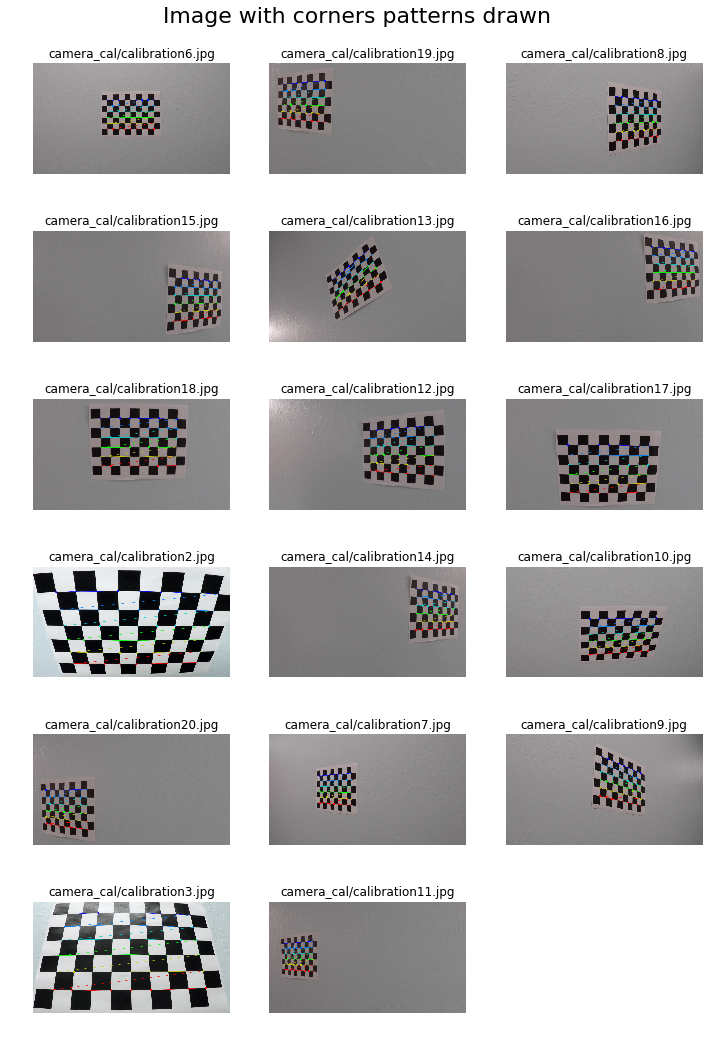

Corners were found on 17 out of 20 it is 85.0 % of calibration images


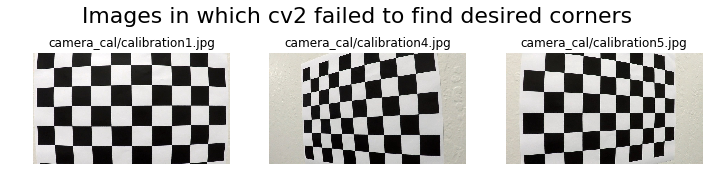

In [13]:
x_cor = 9 #Number of corners to find
y_cor = 6
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((y_cor*x_cor,3), np.float32)
objp[:,:2] = np.mgrid[0:x_cor, 0:y_cor].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('camera_cal/calibration*.jpg') # Make a list of paths to calibration images
# Step through the list and search for chessboard corners
corners_not_found = [] #Calibration images in which opencv failed to find corners
plt.figure(figsize=(12, 18)) #Figure for calibration images
plt.figtext(0.5,0.9,'Image with corners patterns drawn', fontsize=22, ha='center')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Conver to grayscale
    ret, corners = cv2.findChessboardCorners(gray, (x_cor,y_cor), None) # Find the chessboard corners
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        plt.subplot(6, 3, len(imgpoints))
        cv2.drawChessboardCorners(img, (x_cor,y_cor), corners, ret)
        plt.imshow(img)
        plt.title(fname)
        plt.axis('off')
    else:
        corners_not_found.append(fname)
plt.show()

print('Corners were found on', str(len(imgpoints)), 'out of', str(len(images)), 'it is',    str(len(imgpoints)*100.0/len(images)),'% of calibration images')
# Draw pictures
plt.figure(figsize=(12, 4))
plt.figtext(.5,.8,'Images in which cv2 failed to find desired corners', fontsize=22, ha='center')
for i, p in enumerate(corners_not_found):
    plt.subplot(1, 3, i+1)
    plt.imshow(mpimg.imread(p)) #draw the first image of each class
    plt.title(p)
    plt.axis('off')
plt.show()

## Do the calibration given object points and image points

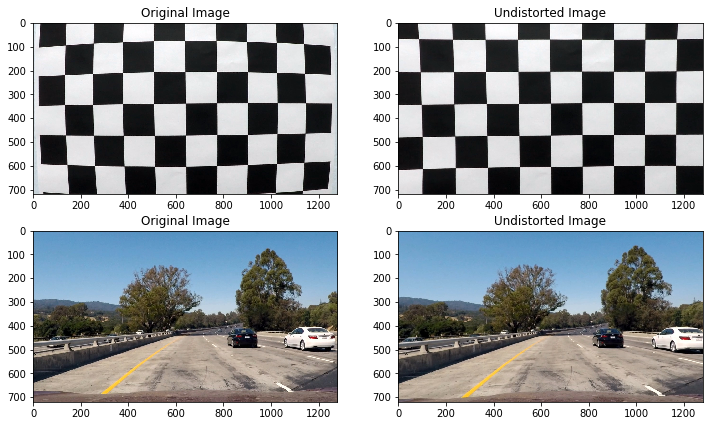

In [14]:
# Undistortion process
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]), None,None)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 2, 2)
plt.imshow(undistort(img))
plt.title("Undistorted Image")
img = cv2.imread('test_images/test1.jpg')
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(undistort(img), cv2.COLOR_BGR2RGB))
plt.title("Undistorted Image")

## Helper Functions to transform image into a thresholded binary image

The following functions were implemented to perform HLS thresholding and binary Sobel transformation. The optimal combination of these filter is able to separate pixels of lane line from background.

In [15]:
# HLS thresholding
def hls_color_thresh(img, threshLow, threshHigh):
    # 1) Convert to HLS color space    
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # 3) Return a binary image of threshold result
    binary_output = np.zeros((img.shape[0], img.shape[1]))
    
    binary_output[(img_hls[:,:,0] >= threshLow[0]) & 
                  (img_hls[:,:,0] <= threshHigh[0]) & 
                  (img_hls[:,:,1] >= threshLow[1])  & 
                  (img_hls[:,:,1] <= threshHigh[1])  & 
                  (img_hls[:,:,2] >= threshLow[2]) & 
                  (img_hls[:,:,2] <= threshHigh[2])] = 1
                 
    return binary_output

# Magnitude threshold
def sobel_x(img, sobel_kernel_size=9, min_thres = 80, max_thres =220):
    # Apply the following steps to img
    # 1) Convert to grayscale
    imghsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Take the gradient in Channels L and S from HLS
    sobelx1 = cv2.Sobel(imghsl[:,:,1], cv2.CV_64F, 1,0, ksize=sobel_kernel_size)
    sobelx2 = cv2.Sobel(imghsl[:,:,2], cv2.CV_64F, 1,0, ksize=sobel_kernel_size)
        
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelx1 = np.uint8(255*sobelx1/ np.max(sobelx1))
    scaled_sobelx2 = np.uint8(255*sobelx2/ np.max(sobelx2))

    # 5) Create a binary mask where mag thresholds are met
    binary_outputx1 = np.zeros_like(scaled_sobelx1)
    binary_outputx1[(scaled_sobelx1 >= min_thres) & (scaled_sobelx1 <= max_thres)] = 1

    binary_outputx2 = np.zeros_like(scaled_sobelx2)
    binary_outputx2[(scaled_sobelx2 >= min_thres) & (scaled_sobelx2 <= max_thres)] = 1

    binary_output = np.zeros_like(scaled_sobelx1)
    binary_output[(binary_outputx1 ==1) | (binary_outputx2 ==1)]=1
    # 6) Return this mask as your binary_output image
    return binary_output


In [16]:
params = {
    'perspective_src' : np.float32([[585, 450], [203, 720], [1127, 720], [695, 450]]),
    'perspective_dst' : np.float32([[320, 0], [320, 720], [960,720], [960, 0]]),
    'hls_yellow_low_thresh' : np.array([0,100,100]),
    'hls_yellow_high_thresh' : np.array([50,255,255]),
    'hls_white_low_thresh' : np.array([18,0,180]),
    'hls_white_high_thresh' : np.array([255,80,255]),
    'sobel_kernel_size' : 9, 
    'sobel_min_thres' : 80,
    'soble_max_thres' : 220,
    'window_margin' : 100,
    'num_windows' : 9,
    'recenter_window_min_pixel' : 50,
    'sanity_min_slope' : 0,
    'sanity_max_slope' : 0.55,
}

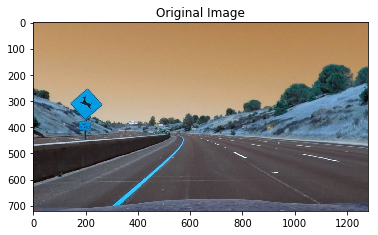

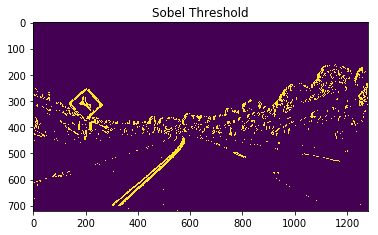

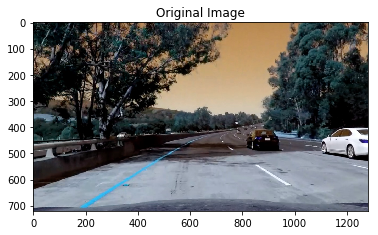

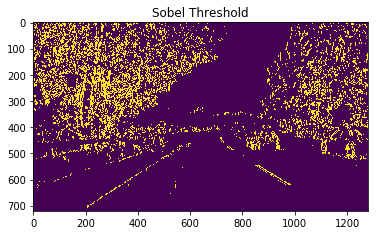

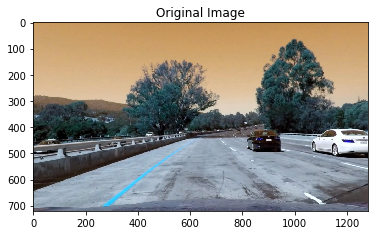

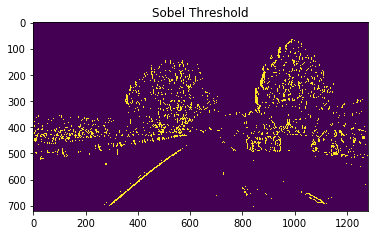

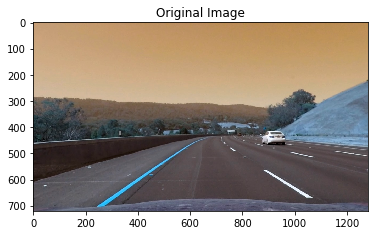

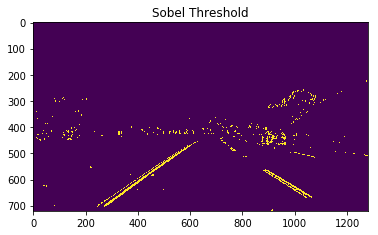

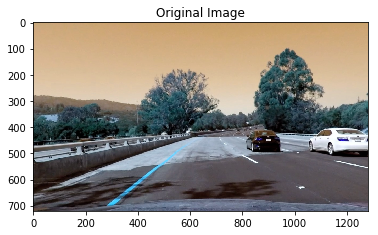

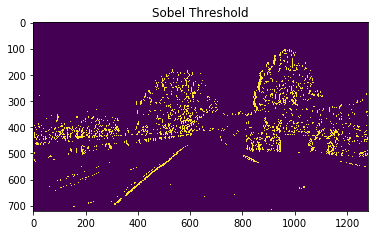

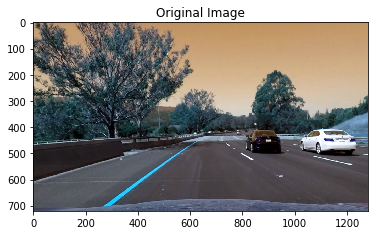

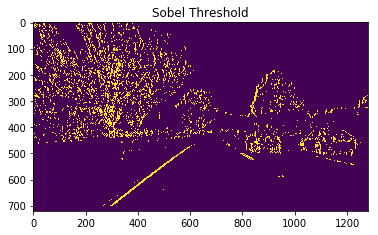

In [17]:
for image in glob.glob('test_images/test*.jpg'):
    img = cv2.undistort(cv2.imread(image), mtx, dist, None, mtx)
    plt.figure()
    plt.subplot(1, 1, 1) 
    plt.imshow(img)
    plt.title("Original Image")
    plt.figure() 
    plt.subplot(1, 1, 1) 
    plt.imshow(sobel_x(img))
    plt.title("Sobel Threshold")

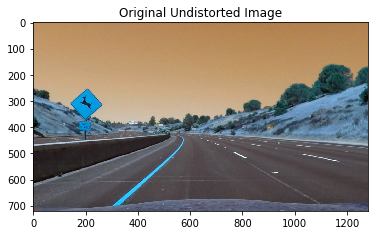

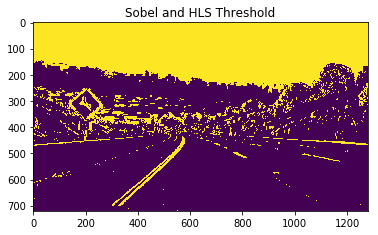

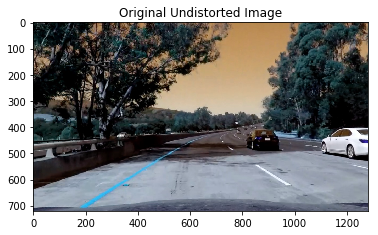

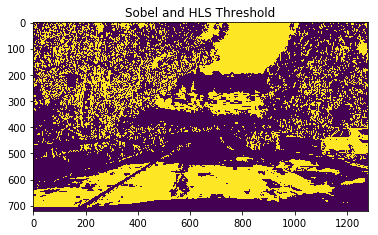

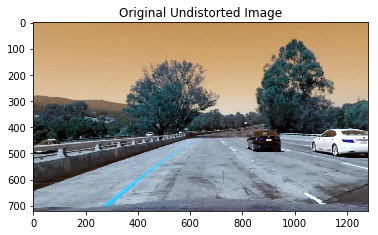

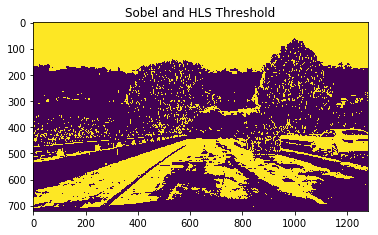

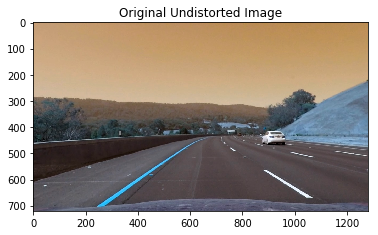

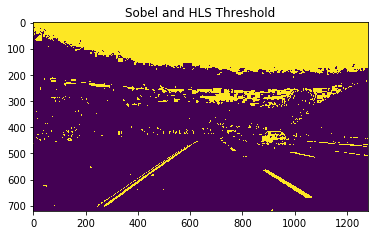

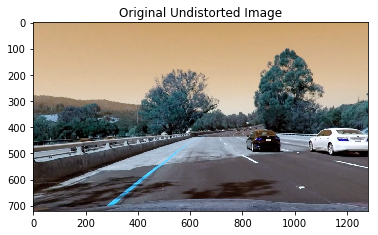

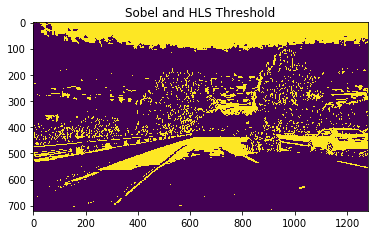

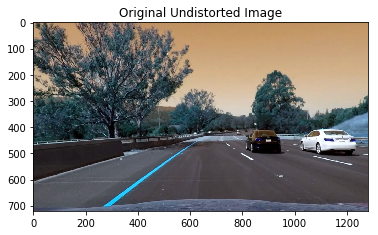

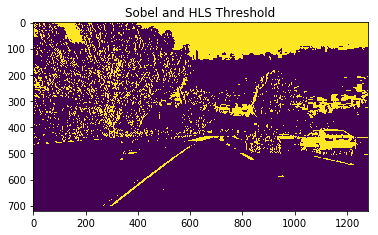

In [18]:
for image in glob.glob('test_images/test*.jpg'):
    img = cv2.undistort(cv2.imread(image), mtx, dist, None, mtx)
    plt.figure()
    plt.subplot(1, 1, 1) 
    plt.imshow(img)
    plt.title("Original Undistorted Image")
    plt.figure() 
    plt.subplot(1, 1, 1) 
    imgThres_yellow = hls_color_thresh(img, params['hls_yellow_low_thresh'], params['hls_yellow_high_thresh'])
    imgThres_white = hls_color_thresh(img, params['hls_white_low_thresh'], params['hls_white_high_thresh'])
    imgThr_sobelx = sobel_x(img, params['sobel_kernel_size'], params['sobel_min_thres'], params['soble_max_thres'])
    img_mag_thr = np.zeros_like(imgThres_yellow)
    img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] = 1
    plt.imshow(img_mag_thr)
    plt.title("Sobel and HLS Threshold")
    

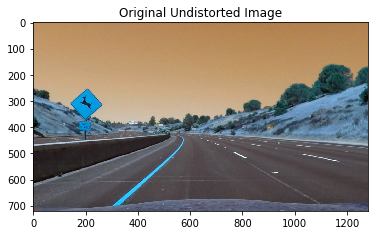

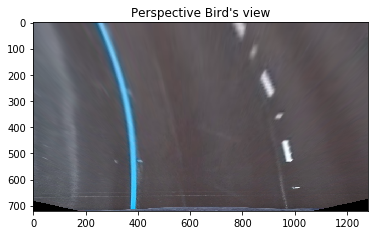

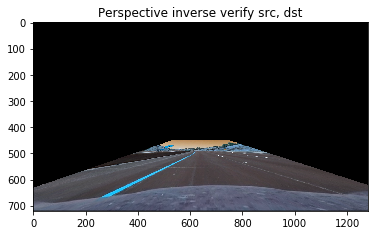

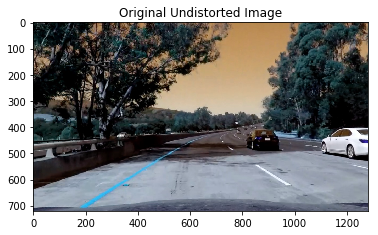

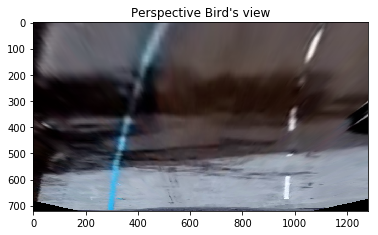

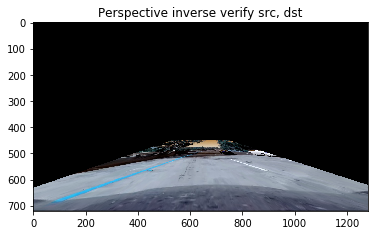

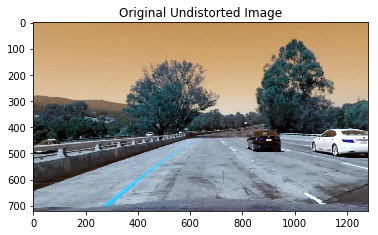

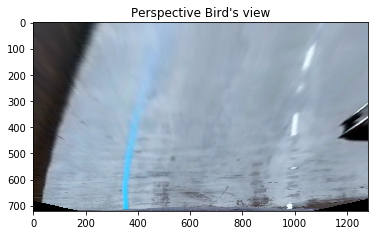

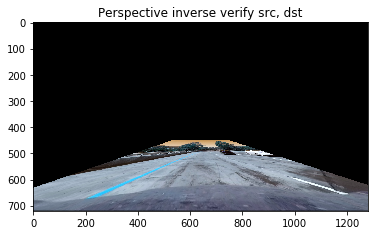

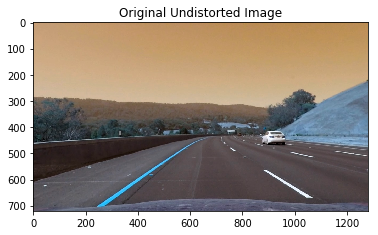

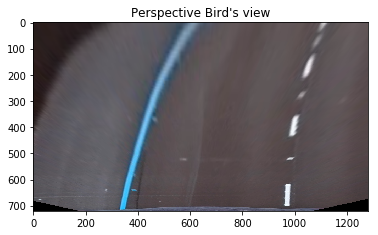

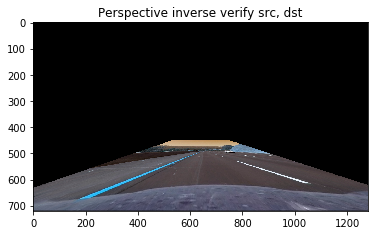

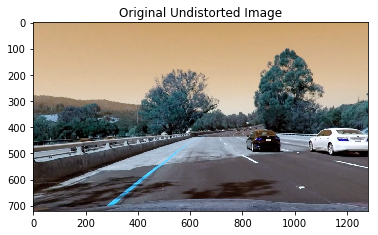

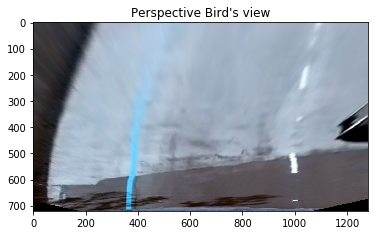

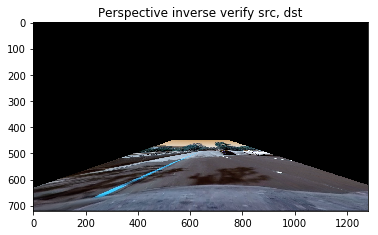

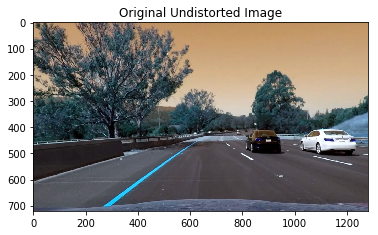

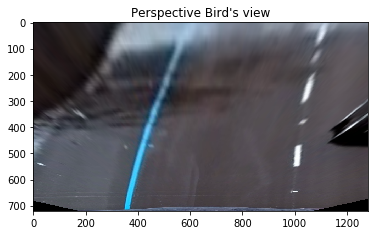

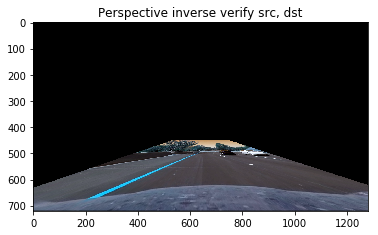

In [19]:
for image in glob.glob('test_images/test*.jpg'):
    img = cv2.undistort(cv2.imread(image), mtx, dist, None, mtx)
    plt.figure()
    plt.subplot(1, 1, 1) 
    plt.imshow(img)
    plt.title("Original Undistorted Image")
    plt.figure() 
    plt.subplot(1, 1, 1) 
    M = cv2.getPerspectiveTransform(params['perspective_src'], params['perspective_dst'])
    plt.imshow(cv2.warpPerspective(img, M, (img_mag_thr.shape[1], img_mag_thr.shape[0]), flags=cv2.INTER_LINEAR))
    plt.title("Perspective Bird's view")
    plt.figure() 
    plt.subplot(1, 1, 1) 
    Minv = cv2.getPerspectiveTransform(params['perspective_dst'], params['perspective_src'])
    plt.imshow(cv2.warpPerspective(img, Minv, (img_mag_thr.shape[1], img_mag_thr.shape[0]), flags=cv2.INTER_LINEAR))
    plt.title("Perspective inverse verify src, dst")
    
    

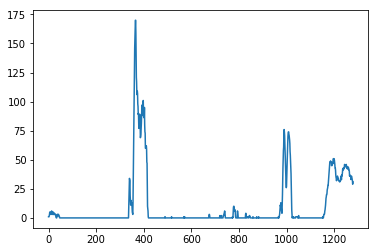

In [20]:
img = cv2.imread("test_images/test1.jpg")
imgThr = sobel_x(img, params['sobel_kernel_size'], params['sobel_min_thres'], params['soble_max_thres'])
M_persp = cv2.getPerspectiveTransform(params['perspective_src'], params['perspective_dst'])
binary_warped = cv2.warpPerspective(imgThr, M_persp, (imgThr.shape[1], imgThr.shape[0]), flags=cv2.INTER_LINEAR)
histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)

In [21]:
def fit_lines(binary_warped, params):
    # Assuming you have created a warped binary image called "binary_warped"
    # Get the histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Set height of sliding window.
    window_height = np.int(binary_warped.shape[0]/  params['num_windows'])
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Get the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    # These will be the starting point for the left and right lines
    leftx_current = np.argmax(histogram[:midpoint])
    rightx_current = np.argmax(histogram[midpoint:]) + midpoint
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds, right_lane_inds = [], []

    # Step through the windows one by one
    for window in range(params['num_windows']):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy < win_y_high) & 
                          (nonzerox >= (leftx_current - params['window_margin'])) & 
                          (nonzerox < (leftx_current + params['window_margin']))).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & 
                           (nonzeroy < win_y_high) & 
                           (nonzerox >= (rightx_current - params['window_margin'])) & 
                           (nonzerox < (rightx_current + params['window_margin']))).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > recenter_window_min_pixel pixels, recenter next window on their mean position
        if len(good_left_inds) > params['recenter_window_min_pixel']:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > params['recenter_window_min_pixel']:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    left_fit, right_fit = [], []
    
    if len(leftx):
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx):
        right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit


In [22]:
# Fit lines in continuous binary warped image (video)
def fit_continuous(binary_warped, left_fit, right_fit, params):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - params['window_margin'])) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + params['window_margin']))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - params['window_margin'])) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + params['window_margin'])))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    left_fit_updated, right_fit_updated = [], []
    
    # Fit a second order polynomial to each
    if len(leftx):
        left_fit_updated = np.polyfit(lefty, leftx, 2)    
    if len(rightx):
        right_fit_updated = np.polyfit(righty, rightx, 2)

    return  left_fit_updated, right_fit_updated


In [23]:
# Calculate Curvature
def curvature(binary_warped, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad, center

In [24]:
#Draw line and return image
def draw_line(undist, Minv,warped,left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (50,255, 50))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

In [25]:
def validity_check(left_fit, right_fit, minSlope, maxSlope):
    #Performs a validity check on the lanes
    #Check 1: check if left and right fits exists
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False
    else:
        #Check 2: Calculates the tangent between left and right in two points, and check if it is in a reasonable threshold
        #Difference of slope
        L_0 = 2*left_fit[0]*460+left_fit[1]
        R_0 = 2*right_fit[0]*460+right_fit[1]
        d0 =  np.abs(L_0-R_0)

        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        d1 =  np.abs(L_1-R_1)
        
        if d0 >= minSlope and d0 <= maxSlope and d1 >= minSlope and d1 <= maxSlope:
            status = True
        else:
            status = False
            
    return status
        

In [26]:

global counter
counter = 0
prev_left_fit = np.array([-0.0001,0,400])
prev_right_fit = np.array([-0.0001,0,1000])   
left_fit = np.array([-0.0001,0,400])
right_fit = np.array([-0.0001,0,1000])  

#Function to process the image
def process_image(image, params=params):
    global counter, right_fit, left_fit, prev_right_fit, prev_left_fit 

    #1. Camera correction
    #Calibration arrays pre-calculated
    img_undist = cv2.undistort(image, mtx, dist, None, mtx)

    #2.Magnitude Threshold
    imgThres_yellow = hls_color_thresh(img_undist, params['hls_yellow_low_thresh'], params['hls_yellow_high_thresh'])
    imgThres_white = hls_color_thresh(img_undist, params['hls_white_low_thresh'], params['hls_white_high_thresh'])
    
    imgThr_sobelx = sobel_x(img_undist, params['sobel_kernel_size'], params['sobel_min_thres'], params['soble_max_thres'])

    img_mag_thr = np.zeros_like(imgThres_yellow)
    img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] = 1

    #3. Birds-eye
    #Perspective array pre-calculated
    M = cv2.getPerspectiveTransform(params['perspective_src'], params['perspective_dst'])
    binary_warped = cv2.warpPerspective(img_mag_thr, M, (img_mag_thr.shape[1], img_mag_thr.shape[0]), flags=cv2.INTER_LINEAR)
    
    #4. Detect lanes and return fit curves
    if counter == 0:
        left_fit, right_fit = fit_lines(binary_warped, params)
    else:
        left_fit, right_fit = fit_continuous(binary_warped, left_fit, right_fit, params)
    
    # perform a sanity check to see if the left and right lines are within a threshold slope
    # if they are within threshold move to next image in the video
    # if not then use the previous line fits
    if validity_check(left_fit, right_fit, params['sanity_min_slope'], params['sanity_max_slope'])  == True:        
        # Save as last reliable fit
        prev_left_fit, prev_right_fit = left_fit, right_fit        
        counter += 1
    else:
        left_fit, right_fit = prev_left_fit, prev_right_fit

    # Calc curvature and center        
    left_curv, right_curv, center_off = curvature(binary_warped, left_fit, right_fit)

    # Warp back to original and merge with image 
    Minv = cv2.getPerspectiveTransform(params['perspective_dst'], params['perspective_src'])
    img_out = draw_line(img_undist, Minv, binary_warped,left_fit, right_fit)


    cv2.putText(img_out,  "Left curv: " + str(int(left_curv)) + " m", (130,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, "Right curv: " + str(int(right_curv))+ " m", (130,70), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, "Center offset: " + str(round( center_off,2)) + " m", (130,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2,  lineType = cv2.LINE_AA)


    return img_out 
    
        

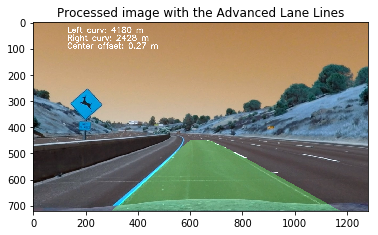

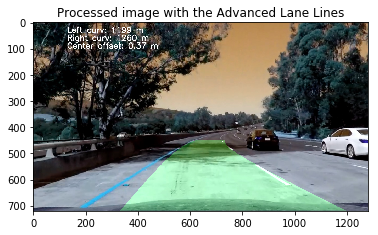

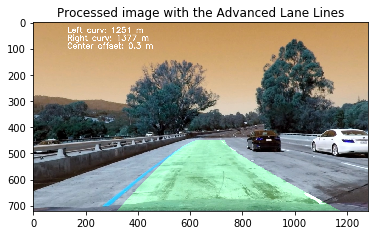

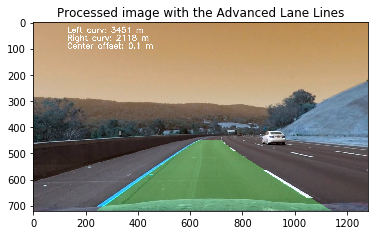

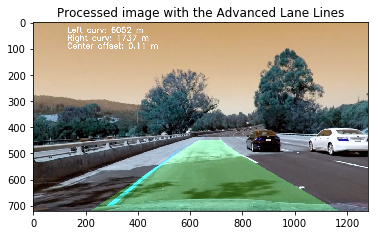

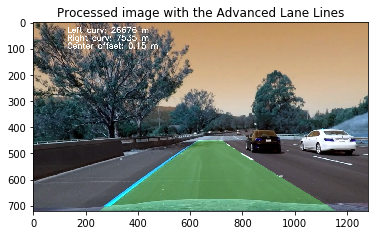

In [28]:
for image in glob.glob('test_images/test*.jpg'):
    plt.figure()
    plt.subplot(1, 1, 1) 
    plt.imshow(process_image(cv2.imread(image)))
    plt.title("Processed image with the Advanced Lane Lines")
    
    

In [18]:
#Create video file pipeline
counter=0
out_clip = VideoFileClip("project_video.mp4").fl_image(process_image)
%time out_clip.write_videofile('project_video_output.mp4', audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:11<00:00,  6.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 14min 24s, sys: 1.97 s, total: 14min 26s
Wall time: 3min 11s


In [19]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_output.mp4'))

In [20]:
#Create video file pipeline
counter=0
out_clip = VideoFileClip("challenge_video.mp4").fl_image(process_image)
%time out_clip.write_videofile('challenge_video_output.mp4', audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [01:08<00:00,  6.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 5min 5s, sys: 872 ms, total: 5min 6s
Wall time: 1min 9s


In [21]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('challenge_video_output.mp4'))

In [22]:
#Create video file pipeline
counter=0
out_clip = VideoFileClip("harder_challenge_video.mp4").fl_image(process_image)
%time out_clip.write_videofile('harder_challenge_video_output.mp4', audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [03:28<00:00,  5.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 15min 18s, sys: 2.2 s, total: 15min 20s
Wall time: 3min 28s


In [23]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('harder_challenge_video_output.mp4'))